## Plot 3d

In [62]:
%matplotlib notebook
import os
import csv
from datetime import datetime as dt  # To check runtime for educational purposes
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_data(batch=0):
    """Generates one dict with data from one batch

    Args:
        batch (int, optional): Batch number. Defaults to 0.

    Returns:
        Dictionary: Keys: t, Q, P, T, V
    """

    start_path = ""
    path = start_path+"project_2_trajectories/datalist_batch_" + str(batch)+".csv"
    with open(path, newline="\n") as file:
        reader = csv.reader(file)
        datalist = list(reader)

    N = len(datalist)
    t_data = np.array([float(datalist[i][0]) for i in range(1, N)])
    Q1_data = [float(datalist[i][1]) for i in range(1, N)]
    Q2_data = [float(datalist[i][2]) for i in range(1, N)]
    Q3_data = [float(datalist[i][3]) for i in range(1, N)]
    P1_data = [float(datalist[i][4]) for i in range(1, N)]
    P2_data = [float(datalist[i][5]) for i in range(1, N)]
    P3_data = [float(datalist[i][6]) for i in range(1, N)]
    T_data = np.array([float(datalist[i][7]) for i in range(1, N)])
    V_data = np.array([float(datalist[i][8]) for i in range(1, N)])

    Q_data = np.transpose(
        np.array([[Q1_data[i], Q2_data[i], Q3_data[i]] for i in range(N-1)]))
    P_data = np.transpose(
        np.array([[P1_data[i], P2_data[i], P3_data[i]] for i in range(N-1)]))

    return {"t": t_data, "Q": Q_data, "P": P_data, "T": T_data, "V": V_data}


print(os.getcwd())

batch_0 = generate_data(0)


# print(len(batch_0))
# print(batch_0['t'])
# print(batch_0['T'])
# print(batch_0['V'])


# plt.plot(batch_0['t'], batch_0['T'], label='Kinetic')
# plt.plot(batch_0['t'], batch_0['V'], label='Potential')
# plt.legend()
# plt.show()

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot(batch_0['Q'][0], batch_0['Q'][1], batch_0['Q'][2])
# # ax.plot(batch_0['Q'][0, 0], batch_0['Q'][1, 0], batch_0['Q'][2, 0], 'or', label=r'$Q_0$')
# # plt.legend()
# plt.show()

C:\Users\kikka\Documents\FYSMAT\5 Semester Høst 2020\Numerisk Matematikk\Project2\CodeForNummatPrj2


# Main

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from datetime import datetime as dt

from givenFncs import generate_data as gdata

# Deletable. Used for debug
np.seterr(all='raise')

"""##################### Example fncs"""


def F2(y):
    return 0.5*y**2


def Fcos(y):
    return 1 - np.cos(y)


def F22(y1, y2):
    return 0.5*(y1**2 + y2**2)


def Fsqrt(y1, y2):
    return - 1 / np.sqrt(y1**2 + y2**2)


"""###################### Simple fncs"""


def σ(x):
    return np.tanh(x)


def dσ(x):
    # return 1 / np.cosh(x)**2 # our
    return 1.0 - np.tanh(x) ** 2


def η(x):  # max [0, 1]
    return (1.0 + np.tanh(x / 2.0)) / 2.0


def dη(x):
    # return 1/(2 * np.cosh(x) + 2) # our
    return 0.25 * (1.0 - np.tanh(x / 2.0) ** 2)


def scale(y, α, β):
    b = np.max(y)
    a = np.min(y)
    return ((b - y)*α + (y - a)*β) / (b-a)

def scaleBack(y, c, α, β):
    b = np.max(c)
    a = np.min(c)
    return y*(b - a)/(β - α) - (b*α - a*β)/(β-α)

In [143]:
"""##################### Classes"""


class Model():
    """Base model:
        It holds startup informasjon about the model and the network used in this method.
    """

    def __init__(self, Y0, C, K, weigths=None):
        """Set values"""
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.C = C  # Ska denna vær init her?
        self.K = K
        self.h = None
        self.j = 0  # Iterations
        self.γ = np.zeros_like(self.C)
        self.Y0 = Y0
        self.ΥmC = self.γ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.γ - self.C)**2
        self.Jθlog = []
        if weigths:  # Imports weigths
            self.startθ = weigths
        else:  # set random weights
            self.startθ = {'W': np.random.rand(self.K, self.d, self.d),
                           'b': np.random.rand(self.K, self.d, 1),
                           'w': np.random.rand(self.d, 1),
                           'μ': np.random.rand()}
        """Memory allocation"""
        self.θ = self._copyWeights(self.startθ)
        self.Z = np.zeros((K+1, self.d, self.I))
        self.Z[0] = Y0
        # One less than intended bc P[0] is not used
        self.P = np.zeros((K, self.d, self.I))
        self.dθ = {'W': np.zeros((self.K, self.d, self.d)),
                   'b': np.zeros((self.K, self.d, 1)),
                   'w': np.zeros((self.d, 1)),
                   'μ': 0}

    def __repr__(self):
        pass

    def __len__(self):
        return self.I

    def _copyWeights(self, weights):
        θ = {'W': weights['W'].copy(),
             'b': weights['b'].copy(),
             'w': weights['w'].copy(),
             'μ': weights['μ']}
        return θ

    def copy(self):
        # θ = {'W': self.θ['W'].copy(),
        #      'b': self.θ['b'].copy(),
        #      'w': self.θ['w'].copy(),
        #      'μ': self.θ['μ']}
        θ = self._copyWeights(self.θ)
        return Model(self.Y0.copy(), self.C.copy(), self.K, θ)

    def computeZ(self, W, b, h, K):  # (4)
        for k in range(K):
            self.Z[k+1] = self.Z[k] + h * σ(W[k] @ self.Z[k] + b[k])

    def backwardPropagation(self, W, b, w, μ, Z, h, K):
        # Save computation
        Zxw = Z[-1].T @ w + μ
        # Update variables (Approximation)
        self.Υ = η(Zxw).T  # (5)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5*np.linalg.norm(self.ΥmC)**2
        # Compute last P[K]
        self.P[self.K-1] = np.outer(w, (self.ΥmC * dη(Zxw).T))  # (10) (verified)
        """Backward propagation"""
        for k in range(K-1, 0, -1):  # Change P index to K+1
            self.P[k-1] = self.P[k] + h*W[k].T @ (dσ(W[k] @ Z[k] + b[k]) * self.P[k])  # (11)

    def computeGradients(self, W, b, w, μ, Z, P, h, K):
        # save computation
        dηZw = dη(Z[K].T @ w + μ)
        # compute (8) and (9)
        self.dθ['μ'] = dηZw.T @ self.ΥmC.T
        self.dθ['w'] = Z[K] @ (self.ΥmC.T * dηZw)
        # Compute (12) and (13)
        for k in range(K):
            # Save computation
            PhadσWZ = h * P[k] * dσ(W[k] @ Z[k] + b[k])
            self.dθ['W'][k] = PhadσWZ @ Z[k].T
            self.dθ['b'][k] = PhadσWZ @ np.ones((self.I, 1))

    def update(self):
        self.computeZ(self.θ['W'], self.θ['b'], self.h, self.K)
        self.backwardPropagation(self.θ['W'], self.θ['b'], self.θ['w'], self.θ['μ'], self.Z, self.h, self.K)
        self.computeGradients(self.θ['W'], self.θ['b'], self.θ['w'], self.θ['μ'], self.Z, self.P, self.h, self.K)

    def restart(self):
        self.θ = self._copyWeights(self.startθ)
        self.j = 0
        self.γ = np.zeros_like(self.C)
        self.ΥmC = self.γ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.γ - self.C)**2


class Adam():
    def __init__(self, model, Jθlogs=None):
        self.M = model
        self.maxiter = None
        self.m = {'W': np.zeros((model.K, model.d, model.d)),
                  'b': np.zeros((model.K, model.d, 1)),
                  'w': np.zeros((model.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()
        # Logging purposes
        self.numLogs = Jθlogs

    def __repr__(self):
        # re = f'Adam, h={self.M.h}, K={self.M.K}, iter={self.maxiter}, Jθ={round(self.M.Jθ, 5)}'
        re = 'Adam'
        return re

    def name(self):
        return 'Adam'

    def algo(self):
        β1 = 0.9
        β2 = 0.999
        α = 0.01
        ϵ = 1e-8
        for key in self.m.keys():
            self.m[key] = β1*self.m[key] + (1-β1)*self.M.dθ[key]
            self.v[key] = β2*self.v[key] + (1-β2)*np.square(self.M.dθ[key])

            m = self.m[key] / (1 - β1**self.M.j)
            v = self.v[key] / (1 - β2**self.M.j)
            self.M.θ[key] -= α * m / (np.sqrt(v) + ϵ)

    def run(self, h, tol, maxiter):
        self.M.h = h
        self.maxiter = maxiter
        self.M.update()
        while self.M.Jθ > tol and self.M.j <= maxiter:
            self.M.j += 1
            self.algo()
            self.M.update()
        self.M.Jθlog.append([self.M.h, self.M.Jθ])


class PVGD():
    """Plain Vanilla Gradient Descent optimizer
    """

    def __init__(self, model):
        self.M = model
        self.τ = None
        self.maxiter = None
        self.log = {}

    def __repr__(self):
        # re = f'PVGD, h={self.M.h}, τ={self.τ}, K={self.M.K}, iter={self.M.j}, Jθ={round(self.M.Jθ, 5)}'
        re = 'PVGD'
        return re

    def name(self):
        return 'PVGD'

    def run(self, h, τ, tol, maxiter, ):
        self.M.h = h
        self.τ = τ
        self.maxiter = maxiter
        self.log[(τ, maxiter)] = []
        while self.M.Jθ > tol and self.M.j < maxiter:
            self.M.j += 1
            self.M.update()
            for key in self.M.θ:
                self.M.θ[key] -= self.τ * self.M.dθ[key]
                # if self.M.j % 10 == 0:
                #     self.log[(τ, maxiter)].append(self.M.Jθ)
            # self.plotProg()

    def plotProg(self):
        if self.M.j % 1000 == 0:
            # plt.plot(self.log[(self.τ, self.maxiter)][:][1], self.log[(self.τ, self.maxiter)][:][0])
            plt.plot(self.M.γ)
            plt.title(f'{self.log.keys()}')
            plt.show()

In [156]:
"""UI fncs"""


def plotApprox(C, *args, x=None):
    if len(x) != 0:
        x = np.linspace(0,1,args[0].M.I)
    for mod in args:
        title = 0
        plt.plot(x, scaleBack(mod.M.Υ[0], C, scaleFrom, scaleTo), label=mod.name() +', h={}'.format(mod.M.h))
    
    if C.shape[0] == 1:
        plt.plot(x, C[0], label='F(y)', ls='--')
    else:
        plt.plot(x, args[0].M.C, label='F(y)', ls='--')
    plt.title(r'Comparing $\tilde{F}(y)$ with $F(y)$')
    plt.legend()
    plt.show()


def findhAdam(m, f, t, n):
    hList = np.linspace(f, t, n)
    Jθlist = []
    hErrorProof = []
    r = 0
    for h in hList:
        r += 1
        try:
            m.run(h, tol, maxiter)
            Jθlist.append(m.M.Jθ)
            hErrorProof.append(h)
            m.M.restart()
            print(f'run {r}/{len(hList)}')
        except Exception as e:
            print(e, 'h =', h)

    plt.plot(hErrorProof, Jθlist)
    plt.xlabel('h')
    plt.ylabel(r'$J(\theta)$')
    plt.show()
    print('done')
    i = Jθlist.index(min(Jθlist))
    print('Best h:', hErrorProof[i])


def findGrad(Opt):
    # extracting paramters
    d = Opt.M.d
    h = Opt.M.h
    K = Opt.M.K
    I = Opt.M.I
    Z = Opt.M.Z.copy()
    w = adamOpt.M.θ['w']
    W = Opt.M.θ['W']
    b = Opt.M.θ['b']

    # algorithm
    A = np.dot(w, dη(np.dot(w.T, Z[K]) + Opt.M.θ['μ']))
    for k in range(K, 0, -1):
        A = A + W[k-1].T @(h * dσ(W[k-1] @ Z[k-1] + b[k-1]) * A)
    return A    
    
def plotLogic(opt):
    pass

In [111]:
"""Run with ex fncs"""
# Setup
np.random.seed()
I = 50
maxiter = 1e4
scaleFrom = 0
scaleTo = 1
# x = np.array([np.linspace(-2, 2, I), np.zeros((I,))])
x = np.array([np.linspace(-2, 2, I), np.linspace(-2, 2, I)])
c = scale(F22(x[0], x[1]), scaleFrom, scaleTo)

# run
mod1 = Model(x, c, 20)  # create instance of model
# Assign optimizer
pvgdOpt = PVGD(mod1)
adamOpt = Adam(mod1.copy())
pvgdOpt.run(0.05, 0.15, 1e-4, maxiter)
adamOpt.run(0.05, 1e-4, maxiter)

<IPython.core.display.Javascript object>


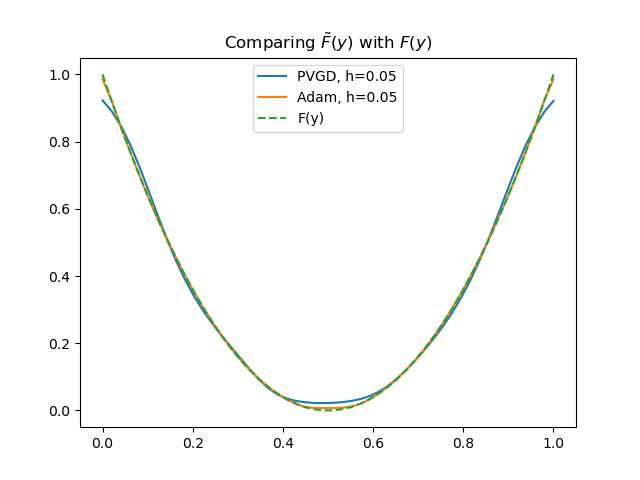

In [121]:
# show
plotApprox(adamOpt.M.C, pvgdOpt, adamOpt)

In [101]:
g = findGrad(adamOpt)

<IPython.core.display.Javascript object>


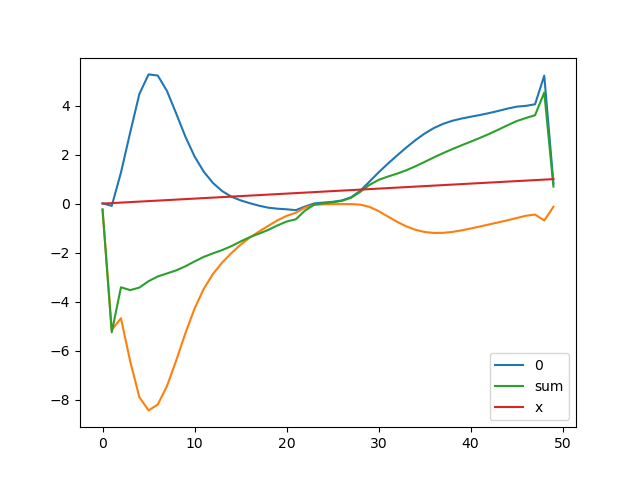

In [103]:
plt.plot(g[0], label='0')
plt.plot(g[1])
plt.plot(g[0] + g[1], label='sum')
plt.plot(x[0], label='x')
plt.legend()
plt.show()

In [163]:
"""Run with batch"""
Ifrom = 0
Ito = 4096
maxiter = 1e4
tol = 1e-5

batch0 = gdata(0)

t = batch0['t'][Ifrom:Ito]
x = batch0['P'][:, Ifrom:Ito]
C_T = np.array([batch0['T'][Ifrom:Ito]])
C_Tscaled = scale(C_T, 0, 1)

mod = Model(x, C_Tscaled, 10)  # create instance of model
adamOptbatch = Adam(mod.copy())

#### Single run
Lager nye vekter ved å kjøre cellen over

In [164]:
h = 0.5
adamOptbatch.run(h, tol, maxiter)

<IPython.core.display.Javascript object>


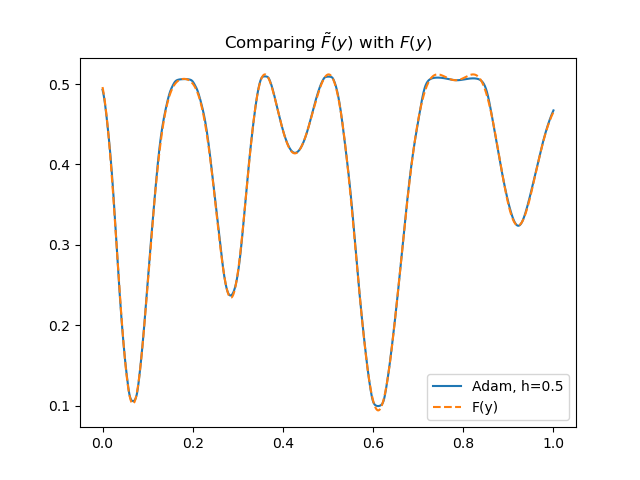

In [165]:
# print(adamOpt.M.Υ[0])

plotApprox(C_T, adamOptbatch, x=t)

<IPython.core.display.Javascript object>


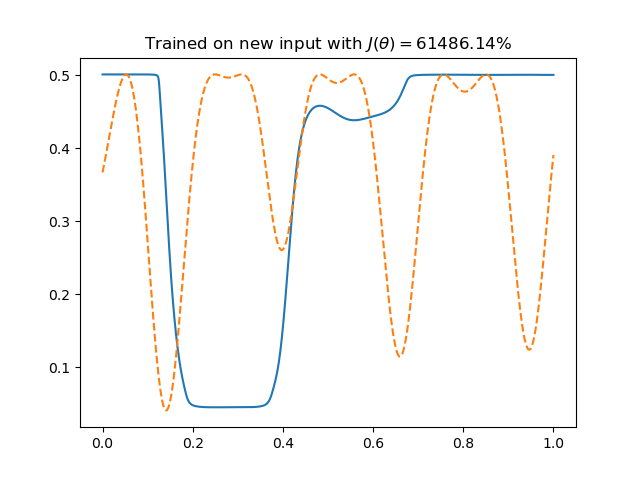

In [181]:
Ifrom = 0
Ito = 4096

batchTest = gdata(1)
m = adamOptbatch
Y = scale(batchTest['P'][:, Ifrom:Ito], 0, 1)
t = scale(batchTest['t'][Ifrom:Ito], 0, 1)
C = np.array([batchTest['T'][Ifrom:Ito]])
C_TtestScaled = scale(C_Ttest, 0, 1)

Z = m.M.Z.copy()
θ = m.M.θ
Z[0] = Y.copy()
for k in range(m.M.K):
    Z[k+1] = Z[k] + m.M.h * σ(θ['W'][k] @ Z[k] + θ['b'][k])
Υ = η(Z[-1].T @ θ['w'] + θ['μ']).T
Jθ = 0.5*np.linalg.norm(Υ - C)**2
# plot
plt.title(r'Trained on new input with $J(\theta) = {}\%$'.format(round(Jθ*100, 2)))
plt.plot(t, scaleBack(Υ[0], C_Ttest[0], 0, 1), label=r'$\thilde{F}(y)$')
plt.plot(t, C_Ttest[0], ls='--')
plt.legend()
plt.show()

In [81]:


gradient = findGrad(adamOpt)

<IPython.core.display.Javascript object>


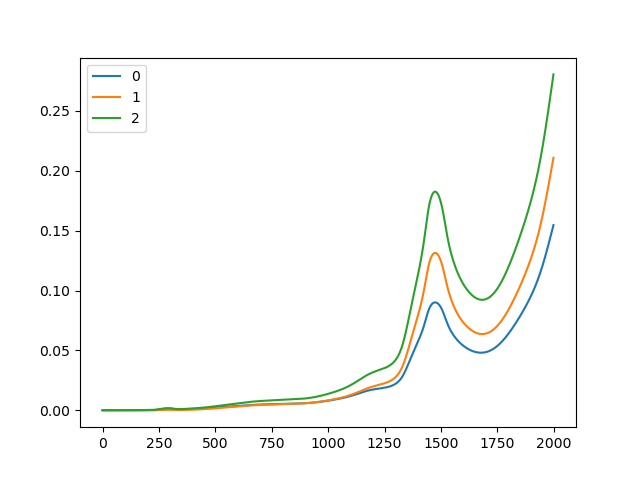

In [159]:
plt.plot(gradient[0], label='0')
plt.plot(gradient[1], label='1')
plt.plot(gradient[2], label='2')
plt.legend()
plt.show()

In [79]:
# Find best h
mod = Model(x, C_T, 10)  # create instance of model
adamOpt = Adam(mod.copy())
n = 7
r = 0
start = dt.now()
findhAdam(adamOpt, 0.01, 0.5, n)
end = dt.now()
print(f'runtime: {end - start}')


print('Done')

run 1/7
run 2/7
run 3/7
run 4/7
run 5/7
run 6/7
run 7/7
done
Best h: 0.09166666666666666
runtime: 0:04:09.333469
Done


In [160]:

print(adamOpt.M.Jθ)

0.00029825673060603276
